In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os
import numpy as np
import xarray as xr
import torch

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../mre_ai')
#import mre_ai.mre_datasets

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
nifti_dirs = [
    'MRE_DICOM_7-31-19',
    'MRE_DICOM_9-12-19',
    'MRE_DICOM_10-09-19',
    'MRE_DICOM_10-22-19'
]

sequences = [
    'dwi',
    'mre',
    'mre_mask',
    'mre_raw',
    'mre_wave',
    'mre_phase',
    #'t1_pos_0_fat',
    #'t1_pos_0_in',
    #'t1_pos_0_out',
    #'t1_pos_0_water',
    #'t1_pos_160_fat',
    #'t1_pos_160_in',
    #'t1_pos_160_out',
    #'t1_pos_160_water',
    #'t1_pos_300_fat',
    #'t1_pos_300_in',
    #'t1_pos_300_out',
    #'t1_pos_300_water',
    #'t1_pos_70_fat',
    #'t1_pos_70_in',
    #'t1_pos_70_out',
    #'t1_pos_70_water',
    #'t1_pre_fat',
    #'t1_pre_in',
    #'t1_pre_out',
    't1_pre_water',
    #'t2',
    'wave'
]

def load_nifti_metadata(nii_file):
    image = sitk.ReadImage(nii_file)
    dim = image.GetDimension()
    size = image.GetSize()
    origin = image.GetOrigin()
    spacing = image.GetSpacing()
    components = image.GetNumberOfComponentsPerPixel()
    type_ = image.GetPixelIDTypeAsString()
    return image, dim, size, origin, spacing, components, type_

import pandas as pd
index_cols = ['nifti_dir', 'patient_id', 'sequence']
df = pd.DataFrame(columns=index_cols).set_index(index_cols)

for nifti_dir in nifti_dirs[:1]:
    print(nifti_dir)
    nifti_dir = os.path.join(data_root, nifti_dir, 'NIFTI')
    patient_ids = sorted(os.listdir(nifti_dir))
    n_patient_ids = len(patient_ids)
    for i, patient_id in enumerate(patient_ids):
        print(f'  [{i+1} / {n_patient_ids}] {patient_id}')
        patient_dir = os.path.join(nifti_dir, patient_id)
        for nii_base in os.listdir(patient_dir):
            if not nii_base.endswith('.nii'):
                continue
            seq = os.path.splitext(nii_base)[0]
            idx = (nifti_dir, patient_id, seq)
            nii_file = os.path.join(nifti_dir, patient_id, nii_base)
            image = sitk.ReadImage(nii_file)
            df.loc[idx, 'dimension'] = image.GetDimension()
            df.loc[idx, 'size'] = str(image.GetSize())
            df.loc[idx, 'origin'] = str(image.GetOrigin())
            df.loc[idx, 'spacing'] = str(image.GetSpacing())
            df.loc[idx, 'components'] = image.GetNumberOfComponentsPerPixel()
            df.loc[idx, 'type'] = image.GetPixelIDTypeAsString()

df

In [ ]:
df.groupby('sequence').nunique()

In [ ]:
df.loc[:,:,['t1_pre_water','mre', 'wave']].groupby(['sequence', 'size']).count()

## Data processing steps

- load SITK images from NIFIT files
- perform filtering/inpainting on wave image
- register images wrt anatomical image
- load segmentation model
- perform image segmentation
- convert images to xarray Dataset

In [55]:
%autoreload
patient = mre_pinn.data.MREPatient(
    data_root='/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI',
    patient_id='0043',
    sequences=['t1_pre_in', 't1_pre_out', 't2']
    #sequences=[
    #    't1_pre_water', 't1_pre_in', 't1_pre_out', 't1_pre_fat', 't2', 'mre_raw', 'wave', 'mre'
    #]
)
patient.load_images()
patient.metadata

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0043/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0043/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0043/t2.nii


size    spacing      origin       limit     center  \
sequence   dimension                                                       
t1_pre_in  0           512   0.703100 -176.651993  182.632120   2.990064   
           1           512   0.703100 -218.074005  141.210108 -38.431949   
           2            96   2.300003 -138.112000   80.388290 -28.861855   
t1_pre_out 0           512   0.703100 -176.651993  182.632120   2.990064   
           1           512   0.703100 -218.074005  141.210108 -38.431949   
           2            96   2.300003 -138.112000   80.388290 -28.861855   
t2         0           256   1.406300 -168.722000  189.884487  10.581243   
           1           256   1.406300 -209.128006  149.478481 -29.824763   
           2            22  10.000000 -135.945999   74.054001 -30.945999   

                          extent  
sequence   dimension              
t1_pre_in  0          359.987213  
           1          359.987213  
           2          220.800293  
t1_pre_out 0          359.987213  
           1          359.987213  
           2          220.800293  
t2         0          360.012787  
           1          360.012787  
           2          220.000000

In [56]:
%autoreload
patient.preprocess_images(register=False, segment=False)

Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t2 to (256, 256, 32)


In [57]:
patient.metadata

size   spacing      origin       limit     center  \
sequence   dimension                                                      
t1_pre_in  0           256  1.406200 -176.300443  182.280570   2.990064   
           1           256  1.406200 -217.722455  140.858558 -38.431949   
           2            32  6.900009 -135.811996   78.088287 -28.861855   
t1_pre_out 0           256  1.406200 -176.300443  182.280570   2.990064   
           1           256  1.406200 -217.722455  140.858558 -38.431949   
           2            32  6.900009 -135.811996   78.088287 -28.861855   
t2         0           256  1.406300 -168.722000  189.884487  10.581243   
           1           256  1.406300 -209.128006  149.478481 -29.824763   
           2            32  6.875000 -137.508499   75.616501 -30.945999   

                          extent  
sequence   dimension              
t1_pre_in  0          359.987213  
           1          359.987213  
           2          220.800293  
t1_pre_out 0          359.987213  
           1          359.987213  
           2          220.800293  
t2         0          360.012787  
           1          360.012787  
           2          220.000000

Converting t1_pre_in to xarray
Converting t1_pre_out to xarray
Converting t2 to xarray


<IPython.core.display.Javascript object>


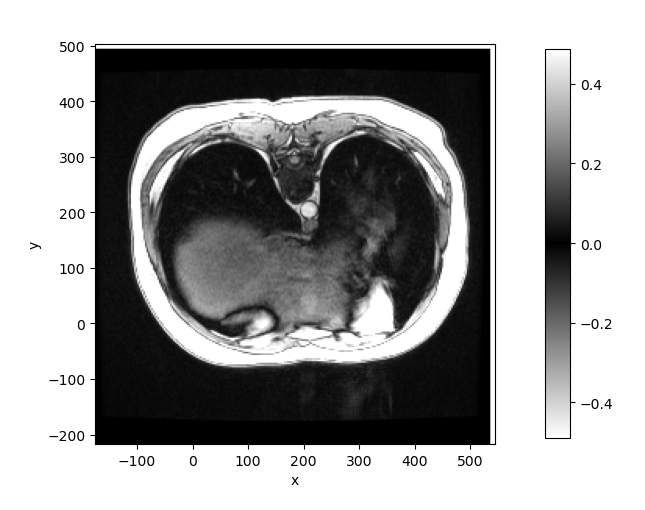

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [58]:
%autoreload
patient.view(compare=True)

In [59]:
model = mre_pinn.data.load_segment_model(device='cuda')
model

Loading segmentation model


UNet3D(
  (down_tr64): DownTransition(
    (ops): Sequential(
      (0): LUConv(
        (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): ContBatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (1): LUConv(
        (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): ContBatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
    )
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_tr128): DownTransition(
    (ops): Sequential(
      (0): LUConv(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): ContBatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (

In [68]:
%autoreload
patient.segment_images(seq='t1_pre_out', model=model)

Segmenting t1_pre_out


Converting t1_pre_in to xarray
Converting t1_pre_out to xarray
Converting t2 to xarray
Converting mask to xarray


<IPython.core.display.Javascript object>


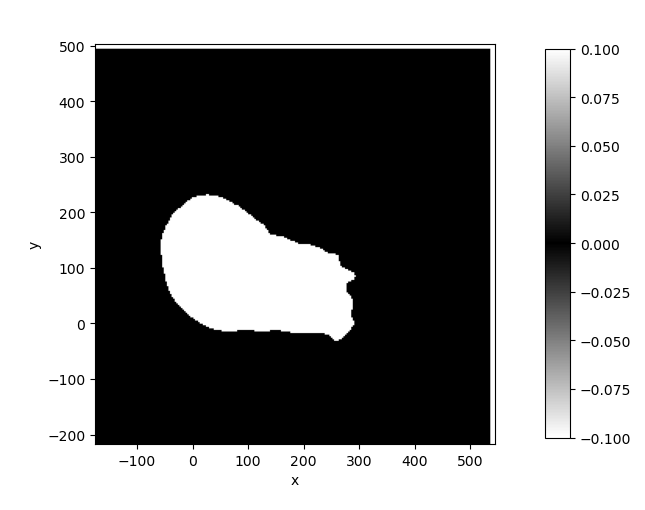

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [69]:
patient.convert_to_xarrays()
patient.view(compare=True)